# Converting a neural network for the Iris dataset into an SFQ circuit

### Install and import packages

In [110]:
#!pip install snntorch torch matplotlib torchvision numpy itertools dsplot

In [111]:
import snntorch as snn
# from mpmath.identification import transforms
# from networkx.algorithms.traversal import dfs_predecessors
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from snntorch import spikeplot as splt
import torch

import matplotlib.pyplot as plt

import torch.nn as nn
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# import numpy as np
# import itertools

from dsplot.graph import Graph
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing


### plotting settings

In [112]:
num_steps=25

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current (Iin)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential (Umem)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()


In [113]:
def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()


In [114]:
def dvs_animator(spike_data):
  fig, ax = plt.subplots()
  anim = splt.animator((spike_data[:,0] + spike_data[:,1]), fig, ax)
  return anim


In [115]:
def find_nearest(biasCurrent, probabilities, val):
    ind = int(len(probabilities)/2)
    last = 0
    while True:
        if probabilities[ind] == val:
            return biasCurrent[ind]
        if val > probabilities[ind]:
            ind, last = int(ind+abs(ind - last)/2), ind
        else:
            ind, last = int(ind-abs(ind - last)/2), ind
        if abs(ind-last) == 1:
            return biasCurrent[ind]
        if ind < 0 or ind > len(probabilities):
            return biasCurrent[last]



### Load data

In [116]:
iris = load_iris()
print(iris.feature_names)
print(iris.target_names)
print(iris.data.shape)
print(iris.target.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 4)
(150,)


/tmp/ipykernel_8797/4057034461.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="target", palette="pastel")


<Axes: xlabel='target', ylabel='count'>

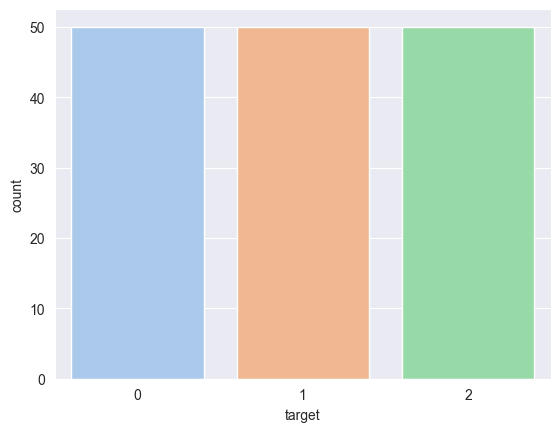

In [117]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

sns.countplot(data=df, x="target", palette="pastel")

In [118]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64


In [119]:
print("Summary statistics:\n", df.describe())

Summary statistics:
        sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  


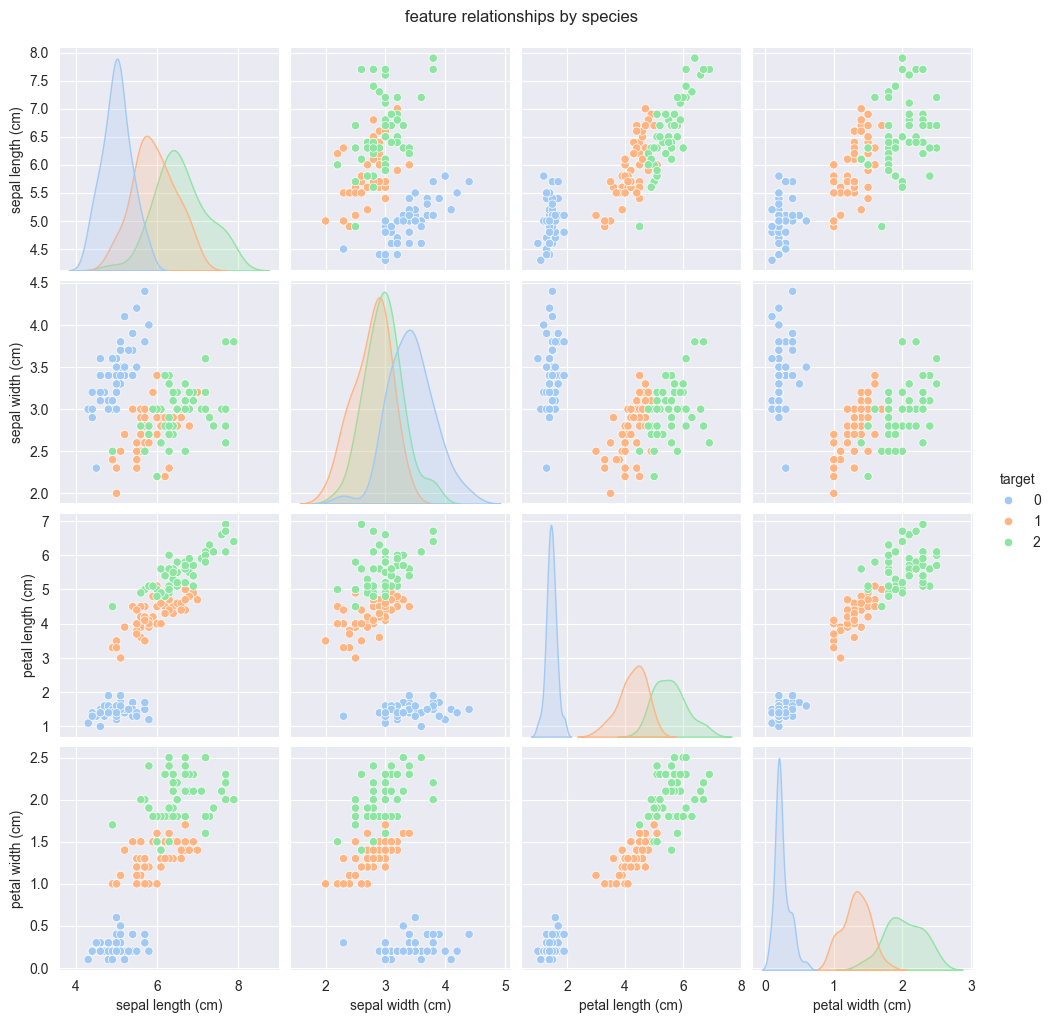

<Figure size 640x480 with 0 Axes>

In [120]:
sns.pairplot(df, hue='target', diag_kind="kde", palette='pastel')
plt.suptitle('feature relationships by species', y=1.02)
plt.show()
plt.savefig('test.png')

##### Preprocessing

In [121]:
X = df.drop('target', axis=1)
targetData = []
for i in iris.target:
    if i == 0:
        targetData.append([1,0,0])
    elif i == 1:
        targetData.append([0,1,0])
    else:
        targetData.append([0,0,1])
y = pd.DataFrame(targetData, columns=iris.target_names)

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [122]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.to_numpy())
y_test = torch.FloatTensor(y_test.to_numpy())

### Create and train the model

In [123]:
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
beta=0.95

In [124]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        #self.input_layer = nn.Linear(input_dim, 128)
        #self.lif1 = snn.Leaky(beta=beta)
        #self.hidden_layer = nn.Linear(128, 64)
        #self.lif2 = snn.Leaky(beta=beta)
        #self.output_layer = nn.Linear(64, output_dim)
        self.lif3 = snn.Leaky(beta=beta)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        #mem1 = self.lif1.init_leaky()
        #mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            #cur1 = self.input_layer(x)
            #spk1, mem1, = self.lif1(cur1)
            #cur2 = self.hidden_layer(spk1)
            #spk2, mem2, = self.lif2(cur2)
            #cur3 = self.output_layer(spk2)
            cur3 = self.fc(x)
            spk3, mem3, = self.lif3(cur3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)


In [125]:
net = Net(4,3).to(device)
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [126]:
def measure_accuracy(model, testData, testResults):
    numcorrect = 0
    for (data, targets) in (zip(testData, testResults)):
        spk_rec, _ = net(data)
        nnResults = spk_rec.mean(0)
        if targets[nnResults.argmax()] == 1:
            numcorrect += 1
    return numcorrect / len(testResults)



In [127]:
def get_f1(model, testData, testResults):
    true_pos = [0,0,0]
    true_neg = [0,0,0]
    false_pos = [0,0,0]
    false_neg = [0,0,0]
    for (data, targets) in (zip(testData, testResults)):
        spk_rec, _ = net(data)
        nnResults = spk_rec.mean(0)
        if targets[nnResults.argmax()] == 1:
            arg = nnResults.argmax()
            true_pos[arg] += 1
            negs = [0,1,2]
            negs.remove(arg)
            for i in negs:
                true_neg[i] += 1
        else:
            for i in range(len(targets)):
                if targets[i] == 1:
                    false_pos[i] += 1
                else:
                    false_neg[i] += 1
    overallPrecision = []
    overallRecall = []
    overallF1 = []
    for i in range(len(true_pos)):
        if (true_pos[i] + false_pos[i])==0:
            overallPrecision.append(0)
        else:
            overallPrecision.append(true_pos[i] / (true_pos[i] + false_pos[i]))
        if (true_pos[i] + false_neg[i]) == 0:
            overallRecall.append(0)
        else:
            overallRecall.append(true_pos[i] / (true_pos[i] + false_neg[i]))
        if overallPrecision[i] + overallRecall[i] > 0:
            overallF1.append(2*overallPrecision[i]*overallRecall[i]/(overallPrecision[i] + overallRecall[i]))
        else:
            overallF1.append(0)

    return overallPrecision, overallRecall, overallF1




In [128]:
num_epochs = 30
counter=0
dtype=torch.float
# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(X_train)
    train_results = iter(y_train)

    # Minibatch training loop
    for (data, targets) in (zip(train_batch, train_results)):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        pH = spk_rec.mean(0)
        loss_val = criterion(pH, targets) # batch x num_out

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Print train/test loss/accuracy
        if counter % 100 == 0:
            print(f"Epoch: {epoch} \t Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1
    if epoch % 5 == 0:
        print(f"Epoch: {epoch+1} \t Train accuracy: {measure_accuracy(net, X_train.to(device), y_train.to(device)):.3f}")
        precision, recall, F1 = get_f1(net, X_train.to(device), y_train.to(device))
        print(f"Epoch: {epoch+1} \t Train F1: {F1}")
        print(f"Epoch: {epoch+1} \t Train Precision: {precision}")
        print(f"Epoch: {epoch+1} \t Train Recall: {recall}")
print(f"Epoch: {epoch} \t Train accuracy: {measure_accuracy(net, X_train.to(device), y_train.to(device)):.3f}")
precision, recall, F1 = get_f1(net, X_train.to(device), y_train.to(device))
print(f"Epoch: {epoch+1} \t Train F1: {F1}")
print(f"Epoch: {epoch+1} \t Train Precision: {precision}")
print(f"Epoch: {epoch+1} \t Train Recall: {recall}")


Epoch: 0 	 Iteration: 0 	 Train Loss: 0.3333333432674408
Epoch: 0 	 Iteration: 100 	 Train Loss: 0.13866665959358215
Epoch: 1 	 Train accuracy: 0.770
Epoch: 1 	 Train F1: [0.7394957983193278, 0.5507246376811594, 0.7256637168141593]
Epoch: 1 	 Train Precision: [1.0, 0.4318181818181818, 0.8723404255319149]
Epoch: 1 	 Train Recall: [0.5866666666666667, 0.76, 0.6212121212121212]
Epoch: 1 	 Iteration: 200 	 Train Loss: 0.13333334028720856
Epoch: 2 	 Iteration: 300 	 Train Loss: 0.19253334403038025
Epoch: 2 	 Iteration: 400 	 Train Loss: 0.24373337626457214
Epoch: 3 	 Iteration: 500 	 Train Loss: 0.2666666805744171
Epoch: 4 	 Iteration: 600 	 Train Loss: 0.20106667280197144
Epoch: 5 	 Iteration: 700 	 Train Loss: 0.11786665767431259
Epoch: 5 	 Iteration: 800 	 Train Loss: 0.14133334159851074
Epoch: 6 	 Train accuracy: 0.859
Epoch: 6 	 Train F1: [0.822429906542056, 0.7466666666666666, 0.822429906542056]
Epoch: 6 	 Train Precision: [1.0, 0.6363636363636364, 0.9361702127659575]
Epoch: 6 	 Train

### metrics

In [129]:
print(f"Test set accuracy: {measure_accuracy(net, X_test.to(device), y_test.to(device)):.3f}")

precision, recall, F1 = get_f1(net, X_test.to(device), y_test.to(device))
print(f"Epoch: {epoch+1} \t Train F1: {F1}")
print(f"Epoch: {epoch+1} \t Train Precision: {precision}")
print(f"Epoch: {epoch+1} \t Train Recall: {recall}")

Test set accuracy: 1.000
Epoch: 30 	 Train F1: [1.0, 1.0, 1.0]
Epoch: 30 	 Train Precision: [1.0, 1.0, 1.0]
Epoch: 30 	 Train Recall: [1.0, 1.0, 1.0]


In [130]:
state_dict = net.state_dict()

op = open('outputProbabilities.csv')
data = op.readlines()
op.close()
biasCurrents = []
probabilities = []
for i in data[1:]:
    placeHold = i.split(',')
    biasCurrents.append(float(placeHold[0]))
    probabilities.append(float(placeHold[1]))


### convert to circuit

In [131]:
op = open('outputProbabilities.csv')
data = op.readlines()
op.close()
biasCurrents = []
probabilities = []
for i in data[1:]:
    placeHold = i.split(',')
    biasCurrents.append(float(placeHold[0]))
    probabilities.append(float(placeHold[1]))

biasCurrents = [x for _, x in sorted(zip(probabilities, biasCurrents))]
probabilities.sort()

In [132]:

relevent=['fc']

synNum=786

points = dict()

circuit = open('testOutputs.cir',"a")
circuit.write('\n')
counter = 6
offset = 6
voltageCounter = 0
finalSynapseLocations = list(range(1,5))

points['inputs'] = []
points['ground'] = [0]
points[0] = []

for i in range(1,6):
    circuit.write("VIN{} {} 0 pulse(0 225u 0 9.1904p 9.1904p 0 20p)\n".format(i,i))
    points[i] = []
    points['inputs'].append(i)

for layer in relevent:
    weights = state_dict[layer+'.weight']
    biases = state_dict[layer+'.bias']
    layerNum = len(weights[0])
    splitEnds = []
    if len(finalSynapseLocations) != 1:
            for i in range(0,len(finalSynapseLocations)):
                splitEnds.append([])
                # X{NUMBER} splitter {input} {out1} {out2}
                for j in range(0,layerNum,2):
                    if j == 0:
                        circuit.write('X{} SPLITTER {} {} {}\n'.format(counter, finalSynapseLocations[i], offset+i*layerNum+j, offset+i*layerNum+j+1))
                        points[finalSynapseLocations[i]].append(offset+i*layerNum+j)
                        points[finalSynapseLocations[i]].append(offset+i*layerNum+j+1)

                        points[offset+i*layerNum+j] = []
                        points[offset+i*layerNum+j+1] = []
                        splitEnds[-1].append(offset+i*layerNum+j)
                        splitEnds[-1].append(offset+i*layerNum+j+1)
                    else:
                        circuit.write('X{} SPLITTER {} {} {}\n'.format(counter, offset+i*layerNum+j-1, offset+i*layerNum+j, offset+i*layerNum+j+1))
                        points[offset+i*layerNum+j-1].append(offset+i*layerNum+j)
                        points[offset+i*layerNum+j-1].append(offset+i*layerNum+j+1)
                        points[offset+i*layerNum+j] = []
                        points[offset+i*layerNum+j+1] = []
                        splitEnds[-1].pop()
                        splitEnds[-1].append(offset+i*layerNum+j)
                        splitEnds[-1].append(offset+i*layerNum+j+1)

                    counter+=1
    counter=offset+i*layerNum+j+2

    finalSynapseLocations = [0]
    for j in range(len(weights)):
        synEnds = []
        for k in range(len(weights[j])):
            biasCurrent = find_nearest(biasCurrents,probabilities,abs(weights[j][k]))
            # X{NUMBER} synapse {input negative} {input positive} {output}
            if weights[j][k] > 0:
                circuit.write("VIN{} {} 0 pwl(0 0 5p {}u)\n".format(counter, counter, biasCurrent))
                counter+=1
                circuit.write("X{} SYNEURON {} {} {}\n".format(counter, counter-1, splitEnds[k][j], counter))
            else:
                circuit.write("VIN{} {} 0 pwl(0 0 5p {}u)\n".format(counter, splitEnds[k][j], biasCurrent))
                counter+=1
                circuit.write("X{} SYNEURON {} 5 {}\n".format(counter, splitEnds[k][j], counter))
            points[splitEnds[k][j]].append(counter)
            points[counter] = []
            synEnds.append(counter)
            counter+=1
        print(layer,"weights written",j)

        if weights[j][k] > 0:
            circuit.write("X{} SYNEURON 5 5 {}\n".format(counter, counter))
        else:
            circuit.write("X{} SYNEURON 5 5 {}\n".format(counter, counter))
        points[counter] = []
        synNum+=1
        counter+=1
        # X{NUMBER} adder {output} {in1} {in2}
        for k in synEnds:
            circuit.write('X{} CONFLU 5 5 {} {} {}\n'.format(counter, counter-1, k, counter))
            points[counter-1].append(counter)
            points[k].append(counter)
            points[counter] = []
            counter+=1
        finalSynapseLocations.append(counter-1)


    offset = synNum
    print(layer,"Layer completed. Mixing signals")

circuit.write(""".temp 4.2
.model jmitll jj(rtype=1, vg=2.8mV, cap=0.07pF, r0=160, rN=16, icrit=0.15mA)
.tran 0.008 220p 0 0.008p
""")

for i in finalSynapseLocations[1:]:
    circuit.write(".print NODEV {} 0\n".format(i))

circuit.write('.end')

graph = Graph(points, directed=True)
graph.plot(fill_color="#aec6cf")


fc weights written 0
fc weights written 1
fc weights written 2
fc Layer completed. Mixing signals
